In [19]:
import matplotlib.pyplot as plt
import math
from matplotlib import colors
import numpy as np
%matplotlib inline  

In [20]:
class Backtrack:
    """This is the skeleton for every backtracking algorithm.
    
    Everyone should have this at least schematically committed to memory.
    """
    
    def backtrack(self, n, s = []):
        """Do the backtracking procedure.

        Implements a kind of pruning, where if we don't find any solutions in an iteration, we stop
        recursing down this branch of the tree.

        The metaphor here is that you make a move (say a piece on a chessboard), test whether there
        are solutions down the tree, unmake the move, then report back up the tree on what you
        found.

        n -- An object to index or carry state of the intrinsic size or nature of the problem
        s -- A potential solution
        return -- The number of solutions in this branch, for pruning purposes

        """
        if (self.is_a_solution(s, n)):
            self.process_solution(s)
            return 1 # At least 1 solution

        nsol_this_branch = 0
        for c in self.construct_candidates(s, n):
            
            self.make_move(s, c)
            
            nsol_that_branch = self.backtrack(n, s)
            if nsol_that_branch == 0:
                self.prune(s, n)
            nsol_this_branch += nsol_that_branch
            
            self.unmake_move(s, c)
        return nsol_this_branch
            


    ## Client might want to reimplement these
    def make_move(self, a, c):
        a.append(c)
    
    def unmake_move(self, a, c):
        a.pop()

    ## Client must implement these
    def is_a_solution(self, a, n): raise NotImplementedError
    def process_solution(self, a): raise NotImplementedError
    def prune(self, a, n): raise NotImplementedError
    


In [21]:
class D4Board:
    """A board class for nqueens that can evaluate symmetries

    We evaulate the symmetries of the system.  The 2D square is a
    representation of Dih4. Using the the generators 
    
    b = horizontal reflection
    c = ccw rotation + vertical rotation / diagonal reflection

    the Cayley graph has a hamiltonian path with the application of the 
    generators in this sequence
    
    e c b c b c b c b -> e

    This means that we can generate all possible 2D square symmetries very
    easily.


    In this system, a
        1 in self.M means that there's a queen there
        2*n for n > 0 counts twice the number of queens attacking that square


    We use two different representations of a board, M, and a queen list, 
    i.e. a simple tuple with the (x,y) indices of each queen on the board.
    
    queen lists are what we save, but inflating to M makes symmetries simpler to handle.
    Ideally you could do away with M.

    """

    def __init__(self, size):
        self.size = size
        
        # This is our board
        self.M = [ [ 0 for i in range(self.size)] for j in range(self.size)]
        
        # A tuple of functions for zipping through the symmetries
        self.cycle = (self.c, self.b, self.c, self.b, self.c, self.b, self.c, self.b)
        
    def b(self):
        """ The 'b' transformation"""
        K = [ [ self.M[j][i] for i in range(self.size-1,-1,-1)] for j in range(self.size)]
        self.M = K
        
    def reflect_horiz(self):
        """ For testing """
        self.b()
    
    def c(self):
        """ The 'c' transformation """
        K = [ [ self.M[j][i] for j in range(self.size)] for i in range(self.size)]
        self.M = K           
    
    def reflect_diag(self):
        """ For testing """
        self.c()
    
    @staticmethod
    def from_queen_list(ql, N):
        """Factory from queen_list
        """
        board = D4Board(N)
        for x in ql:
            board.place_queen(x[0],x[1])
        return board

    def to_queen_list(self):
        """ Converts internal matrix representation to a list of positions. """
        pl = []
        for i,c in enumerate(self.M):
            for j,r in enumerate(c):
                if r == 1:
                    pl.append((i,j))
        return tuple(pl)
    
    def incr_position(self, i,j, incr):
        """Increment a position on the board by incr if it's open.
        
        This blocks out the horizontals, verticals and diagonals attacked by
        a queen placed at (i,j).
        
        We use an arbitray increment `incr' because for simplicity we block in twos. 
        This makes finding the queens easier since we use 1 for queen positions.
        """
        
        for k in range(self.size):
            if k != j:
                self.M[i][k] += incr
            if k != i:
                self.M[k][j] += incr
              
            # Move k increments in every direction
            d0 = (i+k,j+k) if i+k < self.size and j+k < self.size else None
            d1 = (i+k,j-k) if i+k < self.size and j-k > -1 else None
            d2 = (i-k,j+k) if i-k > -1 and j+k < self.size else None
            d3 = (i-k,j-k) if i-k > -1 and j-k > -1 else None
            for d in (d0,d1,d2,d3):
                if d is not None and d != (i,j):
                    l,m = d
                    self.M[l][m] += incr

    def unplace_queen(self, i,j):
        assert(i >= 0 and i < self.size)
        assert(j >= 0 and j < self.size)
        assert(self.M[i][j] == 1)
        self.incr_position(i,j, -2)
        self.M[i][j] = 0
        
    def place_queen(self, i,j):
        assert(i >= 0 and i < self.size)
        assert(j >= 0 and j < self.size)
        assert(self.M[i][j] == 0)
        self.incr_position(i,j, 2)
        assert(self.M[i][j] == 0)
        self.M[i][j] = 1
        
        
    def get_isomorphisms_in(self, s):
        """Produces a tuple of the isomorphisms to the ql representation s. """
        r = []
        for c in self.cycle:
            c()
            ql = self.to_queen_list()
            if ql in s:
                r.append(ql)
        return tuple(r)
        
    def count_isomorphisms_to(self, board):
        """ Counts the isomorphisms of a board """
        r = 0
        for c in self.cycle:
            c()
            if board.M == self.M:
                r += 1
        return r

    def add_isomorphisms_to(self, s):
        """ Adds the isomorphisms of a board to s"""
        for c in self.cycle:
            c()
            s.add(self.to_queen_list())

            
    def show(self, ax):
        B = np.array(self.M)
        min_val, max_val = 0, B.shape[1]

        cmap = colors.ListedColormap(['green','orange', 'white'])
        bounds = [0,1,2,10]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        mat = ax.matshow(B, cmap=cmap, norm=norm)
        for i in range(max_val):
            for j in range(max_val):
                text = B[j][i]
                weight = 'normal'
                if B[j][i] == 1:
                    text = "Q"
                    weight = 'bold'
                text = B[j][i]/2 if B[j][i] != 1 else "Q"
                ax.text(i,j, text, size=14, va='center', ha='center', weight=weight, family='monospace')
        ax.set_xticks(np.arange(-.5, self.size-1, 1));
        ax.set_xticklabels([]);
        ax.xaxis.set_ticks_position('none') 
        ax.set_yticks(np.arange(-.5, self.size-1, 1));
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none')
        ax.grid()

        [i.set_linewidth(2) for i in ax.spines.itervalues()]


In [22]:
import unittest
import copy
import pprint

class TestD4BoardBase(unittest.TestCase):
    def test_empty(self):
        b = D4Board(4)
        V = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
        self.assertEqual(b.M, V)
        
    def test_bounds(self):
        import itertools
        b = D4Board(4)
        x = (-100,-1,0,4,100)
        for p in itertools.permutations(x,2):
            with self.assertRaises(AssertionError):
                b.place_queen(*p)

    def test_single_placement(self):

        D = { (0,0) : [[1, 2, 2, 2], [2, 2, 0, 0], [2, 0, 2, 0], [2, 0, 0, 2]],
              (0,1) : [[2, 1, 2, 2], [2, 2, 2, 0], [0, 2, 0, 2], [0, 2, 0, 0]],
              (0,2) : [[2, 2, 1, 2], [0, 2, 2, 2], [2, 0, 2, 0], [0, 0, 2, 0]],
              (0,3) : [[2, 2, 2, 1], [0, 0, 2, 2], [0, 2, 0, 2], [2, 0, 0, 2]],
              (1,0) : [[2, 2, 0, 0], [1, 2, 2, 2], [2, 2, 0, 0], [2, 0, 2, 0]],
              (1,1) : [[2, 2, 2, 0], [2, 1, 2, 2], [2, 2, 2, 0], [0, 2, 0, 2]],
              (1,2) : [[0, 2, 2, 2], [2, 2, 1, 2], [0, 2, 2, 2], [2, 0, 2, 0]],
              (1,3) : [[0, 0, 2, 2], [2, 2, 2, 1], [0, 0, 2, 2], [0, 2, 0, 2]],
              (2,0) : [[2, 0, 2, 0], [2, 2, 0, 0], [1, 2, 2, 2], [2, 2, 0, 0]],
              (2,1) : [[0, 2, 0, 2], [2, 2, 2, 0], [2, 1, 2, 2], [2, 2, 2, 0]],
              (2,2) : [[2, 0, 2, 0], [0, 2, 2, 2], [2, 2, 1, 2], [0, 2, 2, 2]],
              (2,3) : [[0, 2, 0, 2], [0, 0, 2, 2], [2, 2, 2, 1], [0, 0, 2, 2]], 
              (3,0) : [[2, 0, 0, 2], [2, 0, 2, 0], [2, 2, 0, 0], [1, 2, 2, 2]],
              (3,1) : [[0, 2, 0, 0], [0, 2, 0, 2], [2, 2, 2, 0], [2, 1, 2, 2]],
              (3,2) : [[0, 0, 2, 0], [2, 0, 2, 0], [0, 2, 2, 2], [2, 2, 1, 2]],
              (3,3) : [[2, 0, 0, 2], [0, 2, 0, 2], [0, 0, 2, 2], [2, 2, 2, 1]]
        }

        for k,v in D.items():
            b = D4Board(4)
            b.place_queen(*k)
            self.assertEqual(b.M, v)

    def test_multiple_placement(self):
        b = D4Board(4)
        b.place_queen(2,0)
        b.place_queen(1,2)
        self.assertEqual(b.M, [[2, 2, 4, 2], [4, 4, 1, 2], [1, 4, 4, 4], [4, 2, 2, 0]])

    def test_from_queen_list(self):
        ql = ((1,2), (2,0))
        b = D4Board.from_queen_list(ql, 4)
        self.assertEqual(b.M, [[2, 2, 4, 2], [4, 4, 1, 2], [1, 4, 4, 4], [4, 2, 2, 0]])
        self.assertEqual(ql, b.to_queen_list())
        
        
    def test_open_position(self):
        b = D4Board(4)
        b.place_queen(2,0)
        b.place_queen(1,2)
        self.assertEqual(b.M, [[2, 2, 4, 2], [4, 4, 1, 2], [1, 4, 4, 4], [4, 2, 2, 0]])
        b.unplace_queen(2,0)
        self.assertEqual(b.M, D4Board.from_queen_list([(1,2)],4).M)

    def test_reflect_horiz(self):
        b = D4Board(4)
        b.place_queen(0,0)
        M1 = b.M
        self.assertEqual(M1, [[1, 2, 2, 2], [2, 2, 0, 0], [2, 0, 2, 0], [2, 0, 0, 2]])
        b.reflect_horiz()
        M2 = b.M
        self.assertEqual(M2, [[2, 2, 2, 1], [0, 0, 2, 2], [0, 2, 0, 2], [2, 0, 0, 2]])
        b.reflect_horiz()
        self.assertEqual(b.M, M1)

    def test_reflect_diag_symmetric(self):
        b = D4Board(4)
        b.place_queen(0,0)
        M1 = b.M
        self.assertEqual(M1, [[1, 2, 2, 2], [2, 2, 0, 0], [2, 0, 2, 0], [2, 0, 0, 2]])
        b.reflect_diag()
        self.assertEqual(b.M, M1)

    def test_reflect_diag_asymmetric(self):
        b = D4Board(4)
        b.place_queen(1,0)
        M1 = b.M
        self.assertEqual(M1, [[2, 2, 0, 0], [1, 2, 2, 2], [2, 2, 0, 0], [2, 0, 2, 0]])
        b.reflect_diag()
        self.assertEqual(b.M, [[2, 1, 2, 2], [2, 2, 2, 0], [0, 2, 0, 2], [0, 2, 0, 0]])
        b.reflect_diag()
        self.assertEqual(b.M, M1)

    def test_cycle_manual(self):
        b = D4Board(4)
        b.place_queen(1,0)
        M1 = b.M
        b.reflect_diag()
        b.reflect_horiz()
        b.reflect_diag()
        b.reflect_horiz()
        b.reflect_diag()
        b.reflect_horiz()
        b.reflect_diag()
        b.reflect_horiz()
        self.assertEqual(b.M, M1)

    def test_cycle(self):
        b = D4Board(4)
        b.place_queen(1,0)
        M1 = b.M
        [ c() for c in b.cycle ]
        self.assertEqual(b.M, M1)

    def test_self_iso(self):
        b = D4Board(4)
        b.place_queen(1,0)
        b2 = D4Board(4)
        b2.place_queen(1,0)
        self.assertEqual(b.count_isomorphisms_to(b2), 1)
        b2.reflect_diag()
        self.assertEqual(b.count_isomorphisms_to(b2), 1)
        b2.reflect_horiz()
        self.assertEqual(b.count_isomorphisms_to(b2), 1)
        b2.reflect_diag()
        self.assertEqual(b.count_isomorphisms_to(b2), 1)
        b2.reflect_horiz()
        self.assertEqual(b.count_isomorphisms_to(b2), 1)
        b2.reflect_diag()
        self.assertEqual(b.count_isomorphisms_to(b2), 1)
        b2.reflect_horiz()
        self.assertEqual(b.count_isomorphisms_to(b2), 1)
        b2.reflect_diag()
        self.assertEqual(b.count_isomorphisms_to(b2), 1)
        b2.reflect_horiz()
        self.assertEqual(b.count_isomorphisms_to(b2), 1)

    def test_no_iso(self):
        b1 = D4Board(4)
        b1.place_queen(1,0)
        b2 = D4Board(4)
        b2.place_queen(3,3)
        self.assertEqual(b1.count_isomorphisms_to(b2), 0)
        self.assertEqual(b2.count_isomorphisms_to(b1), 0)        


    def test_iso_in(self):
        b0 = D4Board(4)
        b0.place_queen(1,0)
        
        ql = b0.to_queen_list()
        s = set()
        s.add(ql)

        b1 = D4Board(4)
        b1.place_queen(3,0) # 3,0 not isomoporphic to (1,0)
        s.add(b1)

        self.assertTrue(ql in s)
        self.assertEqual(b0.get_isomorphisms_in(s), (ql,))

    def test_add_isos_to(self):
        b = D4Board(4)
        b.place_queen(1,0)

        s = set()
        b.add_isomorphisms_to(s)
        self.assertEqual(s, set([((1, 0),), ((0, 1),), ((3, 2),), ((0, 2),), 
                                 ((1, 3),), ((3, 1),), ((2, 0),), ((2, 3),)]))
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_add_isos_to (__main__.TestD4BoardBase) ... ok
test_bounds (__main__.TestD4BoardBase) ... ok
test_cycle (__main__.TestD4BoardBase) ... ok
test_cycle_manual (__main__.TestD4BoardBase) ... ok
test_empty (__main__.TestD4BoardBase) ... ok
test_from_queen_list (__main__.TestD4BoardBase) ... ok
test_iso_in (__main__.TestD4BoardBase) ... ok
test_multiple_placement (__main__.TestD4BoardBase) ... ok
test_no_iso (__main__.TestD4BoardBase) ... ok
test_open_position (__main__.TestD4BoardBase) ... ok
test_reflect_diag_asymmetric (__main__.TestD4BoardBase) ... ok
test_reflect_diag_symmetric (__main__.TestD4BoardBase) ... ok
test_reflect_horiz (__main__.TestD4BoardBase) ... ok
test_self_iso (__main__.TestD4BoardBase) ... ok
test_single_placement (__main__.TestD4BoardBase) ... ok
test (__main__.TestNqueens) ... ok

----------------------------------------------------------------------
Ran 16 tests in 0.657s

OK


In [23]:
class NQueens(Backtrack): 
    def __init__(self, board_size):
        self.board_size = board_size
        self.solutions = set()        
        self.rejected = set()
        self.nrejected = dict()
        self.do_prune = True
    
    def construct_candidates(self, a, n):
        b = D4Board.from_queen_list(a, self.board_size)
        c = []
        # Scan the board for open positions
        for i in range(self.board_size):
            for j in range(self.board_size):
                if b.M[i][j] == 0:
                    b.place_queen(i,j)
                    ql = b.to_queen_list()
                    if ql in self.rejected:
                        ql = tuple(sorted(tuple(ql)))
                        if not ql in self.nrejected:
                            self.nrejected[ql] = 0
                        self.nrejected[ql] += 1
                    else:
                        c.append((i,j))
                    b.unplace_queen(i,j)
        
        if len(c) + len(a) < n:
            # Then there's no point, we don't have enough candidates to get to n
            return []        
        return c

    def is_a_solution(self, a,n):
        return len(a) == n

    def process_solution(self, a):
        a = tuple(sorted(tuple(a)))
        self.solutions.add(a)
        # Suppresses duplicates
        self.rejected.add(a)
        D4Board.from_queen_list(a, self.board_size).add_isomorphisms_to(self.rejected)
    
    def prune(self, a, n):
        # if n == len(a), those would be solutions. We took care of them in process_solutions. 
        # So these are only isomorphisms that were ruled out for other reasons
        if self.do_prune and len(a) < n:
            D4Board.from_queen_list(a, self.board_size).add_isomorphisms_to(self.rejected)

    def show_solutions(self):
        def fit_column(a):
            for t in (8,7,6,5,4,3,2):
                if a%t == 0:
                    return t
            return 1
        
        NS = len(self.solutions)
        ncol = fit_column(NS)
        nrows = NS//ncol + (1 if NS%ncol > 0 else 0)

        if nrows < 2:
            f, axs = plt.subplots(1,ncol, sharex=True, sharey=True, figsize=(ncol*3,nrows*3))
            get_ax = lambda i, ax: ax[i] if ncol > 1 else ax
        else:
            f, axs = plt.subplots(nrows, ncol, sharex=True, sharey=True, figsize=(ncol*3,nrows*3))
            get_ax = lambda i, ax: ax[i//ncol,i%ncol]

        for i, ql in enumerate(self.solutions):
            B = D4Board.from_queen_list(ql, self.board_size)
            B.show(get_ax(i,axs))
        plt.subplots_adjust(wspace=0.05,hspace=0.05)
        plt.show()
    

In [27]:
class TestNqueens(unittest.TestCase):
    SOLUTIONS = (1, 0, 0, 1, 2, 1, 6)
    def test(self):
        for i, n in enumerate(self.SOLUTIONS):
            NQueens(i+1).backtrack(i+1)
unittest.main(argv=[''], verbosity=2, exit=False)

test_add_isos_to (__main__.TestD4BoardBase) ... ok
test_bounds (__main__.TestD4BoardBase) ... ok
test_cycle (__main__.TestD4BoardBase) ... ok
test_cycle_manual (__main__.TestD4BoardBase) ... ok
test_empty (__main__.TestD4BoardBase) ... ok
test_from_queen_list (__main__.TestD4BoardBase) ... ok
test_iso_in (__main__.TestD4BoardBase) ... ok
test_multiple_placement (__main__.TestD4BoardBase) ... ok
test_no_iso (__main__.TestD4BoardBase) ... ok
test_open_position (__main__.TestD4BoardBase) ... ok
test_reflect_diag_asymmetric (__main__.TestD4BoardBase) ... ok
test_reflect_diag_symmetric (__main__.TestD4BoardBase) ... ok
test_reflect_horiz (__main__.TestD4BoardBase) ... ok
test_self_iso (__main__.TestD4BoardBase) ... ok
test_single_placement (__main__.TestD4BoardBase) ... ok
test (__main__.TestNqueens) ... ok

----------------------------------------------------------------------
Ran 16 tests in 0.660s

OK


6


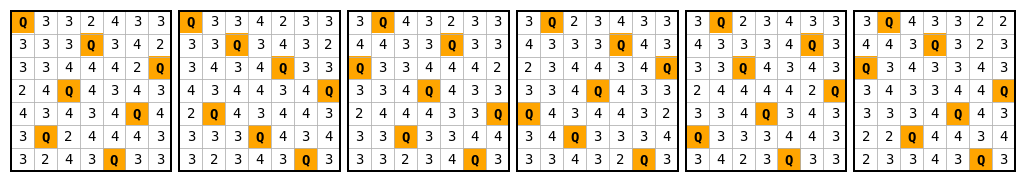

In [29]:
N = 7
NQ = NQueens(N)
NQ.backtrack(N)
print(len(NQ.solutions))
NQ.show_solutions()

### Effect of pruning

In [229]:
N = 6
%timeit NQ = NQueens(N); NQ.do_prune = True; NQ.backtrack(N)

10 loops, best of 3: 74.5 ms per loop


In [230]:
N = 6
%timeit NQ = NQueens(N); NQ.do_prune = False; NQ.backtrack(N)

1 loop, best of 3: 2.39 s per loop
